In [42]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [43]:
df = pd.read_csv("../data/train.csv", index_col=0)
df.head(2)

,red_card_continent,age,nation,league,team,goals_selection,selections_nation,position,price,goal_champ,...,assist_cup,own_goal_cup,yellow_card_cup,second_yellow_card_cup,red_card_cup,goal_continent,assist_continent,own_goal_continent,yellow_card_continent,second_yellow_card_continent
1019,0.0,23,Tunisia,Ligue1,OGCNice,0,4,Goalkeeper,1000000.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
1892,0.0,20,CzechRepublic,FortunaLiga,1.FKPribram,0,1,LeftWinger,100000.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df_clubs_rating = pd.read_csv('../data/Clubs-Ranking.csv')
df_clubs_rating.head(2)

,ranking,club name,country,point score,1 year change,previous point scored,symbol change
0,88,1. FC Köln,Germany,1633,105,1545,+
1,74,1. FC Union Berlin,Germany,1655,5,1654,+


In [45]:
df_country_continent = pd.read_csv('../data/Countries-Continents.csv')
df_country_continent

,Continent,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina
...,...,...
189,South America,Paraguay
190,South America,Peru
191,South America,Suriname
192,South America,Uruguay


In [46]:
len(df.team.unique())

1049

In [47]:
df.team.isin(list(df_clubs_rating['club name '].unique())).sum()

879

In [48]:
list(df.team.unique()) in list(df_clubs_rating['club name '].unique())

False

In [49]:
df.columns

Index(['red_card_continent', 'age', 'nation', 'league', 'team',
       'goals_selection', 'selections_nation', 'position', 'price',
       'goal_champ', 'assist_champ', 'own_goal_champ', 'yellow_card_champ',
       'second_yellow_card_champ', 'red_card_champ', 'goal_cup', 'assist_cup',
       'own_goal_cup', 'yellow_card_cup', 'second_yellow_card_cup',
       'red_card_cup', 'goal_continent', 'assist_continent',
       'own_goal_continent', 'yellow_card_continent',
       'second_yellow_card_continent'],
      dtype='object')

In [50]:
#df['league'].unique()
df.selections_nation	
df.league.unique()

array(['Ligue1', 'FortunaLiga', 'SuperLiga', 'JupilerProLeague',
       'PremierLiga', 'J1League', 'SüperLig', 'PersianGulfProLeague',
       'PrimeraDivisión', 'SerieA', 'PremierLeague', 'ABSAPremiership',
       'NationalLeague', 'LigueProfessionnelle1', 'ThaiLeague',
       'SuperLeague', 'SérieB', "Ligatha'Al", 'Superliga', 'LaLiga',
       'NewZealandPremiership', 'ProfessionalLeague', 'StarsLeague',
       'LigaNOS', 'Liga1', 'UAEGulfLeague', 'AscensoMXClausura',
       'Eredivisie', 'Allsvenskan', 'FirstDivision', 'LigueIPro',
       'AzadeganLeague', 'BotolaPro', 'Ekstraklasa', 'USLC', 'Bundesliga',
       'J2League', 'A0League', 'SérieA', 'V.League1', 'PrimeraBNacional',
       'HongKongPL', 'PrimeraDiv.Clausura', 'MLS', 'KLeague2',
       'LeagueOne', 'LigaMXClausura', 'Superligaen', 'TorneoApertura',
       '1.HNL', 'KLeague1', 'LigaÁguilaI', 'BangladeshPL', 'Premiership',
       'ParvaLiga', 'IndianSuperLeague', 'I0League',
       'I0League2ndDivision', 'KeukenKampioenDivis

## https://www.fifa.com/fifa-world-ranking

In [96]:
class FeatureEngineeringDf:
  def __init__(self, df):
    self.df = df
    self.top_leagues = ['Ligue1', 'PremierLeague', 'LaLiga', 'SerieA', 'Bundesliga']
    self.top2_leagues = ['Eredivisie', 'LigaNOS', 'MLS', 'SérieA', 'LigaMXClausura', 'PremierLiga','JupilerProLeague', '']
    self.all_top_leagues = self.top2_leagues + self.top_leagues
    self.top_nations = ['Brazil', 'Spain', 'France', 'Germany', 'Belgium', 'Argentina', 'Italy','England', 'Portugal','Mexico','Netherlands','Denmark']
    self.top2_nations = ['Uruguay', 'Switzerland', 'USA', 'Croatia', 'Colombia', 'Wales', 'Sweden','Senegal', 'Iran','Peru','Japan','Morocco', 'Serbia', 'Poland', 'Chile']
    self.all_top_nations = self.top_nations + self.top2_nations
    self.worst_leagues = []
    self.worst_nations = []
    self.condlist_top_leagues = [
        self.df['league'].isin(self.top_leagues),
        self.df['league'].isin(self.top2_leagues),
        ~self.df['league'].isin(self.all_top_leagues),
    ]
    self.condlist_top_nations = [
        self.df['nation'].isin(self.top_nations),
        self.df['nation'].isin(self.top2_nations),
        ~self.df['nation'].isin(self.all_top_nations),
    ]
    #self.init_dtypes()

  def numeric_dtypes(self):
    cat_cols = self.df.select_dtypes('object')
    for col in cat_cols:
      self.df[col] = self.df[col].astype('category').cat.codes

    
  def add_goals_value(self):
    choicelist_cup = [
        self.df['goal_cup']*2,
        self.df['goal_cup']*1.5,
        self.df['goal_cup'],
    ]
    self.df['score_goal_cup'] = np.select(self.condlist_top_leagues, choicelist_cup, default=0)
    choicelist_champ = [
        self.df['goal_champ']*2,
        self.df['goal_champ']*1.5,
        self.df['goal_champ'],
    ]
    self.df['score_goal_champ'] = np.select(self.condlist_top_leagues, choicelist_champ, default=0)

    choicelist_champ = [
        self.df['goals_selection']*2,
        self.df['goals_selection']*1.5,
        self.df['goals_selection'],
    ]
    self.df['score_goals_selection'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)
  
  def add_assists_value(self):
    choicelist_cup = [
        self.df['assist_cup']*2,
        self.df['assist_cup']*1.5,
        self.df['assist_cup'],
    ]
    self.df['score_assist_cup'] = np.select(self.condlist_top_leagues, choicelist_cup, default=0)
    choicelist_champ = [
        self.df['assist_champ']*2,
        self.df['assist_champ']*1.5,
        self.df['assist_champ'],
    ]
    self.df['score_assist_champ'] = np.select(self.condlist_top_leagues, choicelist_champ, default=0)

  def add_champions_score(self):
    # dividir continents --> TO DO
    """
      choicelist_champ = [
          self.df['assist_continent']*2,
          self.df['assist_continent']*1.5,
          self.df['assist_continent'],
      ]
      self.df['score_assist_continent'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)

      choicelist_champ = [
          self.df['goal_continent']*2,
          self.df['goal_continent']*1.5,
          self.df['goal_continent'],
      ]
      self.df['score_goal_continent'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)
    """

  
  def add_nations_value(self):
    choicelist_champ = [
        self.df['selections_nation']*2,
        self.df['selections_nation']*1.5,
        self.df['selections_nation'],
    ]
    self.df['score_selections_nation'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)
  
  def filter_by_position(self, filter=0):
    if filter == 0:
      return self.df[self.df.position.isin(['Goalkeeper'])]
    elif filter == 1:
      return self.df[self.df.position.isin([ 'DefensiveMidfield','Defender'])]
    elif filter == 2:
      return self.df[self.df.position.isin(['LeftMidfield' , 'CentralMidfield', 'Midfielder', 'AttackingMidfield','RightMidfield'])]
    else:
      return self.df[self.df.position.isin(['SecondStriker', 'Forward','LeftWinger','RightWinger'])]
  
  def filter_top_leagues(self, filter_positions=True, positions = ['SecondStriker', 'Forward']):
    top_league_players = self.df[self.df.league.isin(self.top_leagues)]
    if filter_positions:
      top_league_players[top_league_players.position.isin(positions)]
    return top_league_players
  
  def data_correlated(self,label_col_name='price', thr = 0.05):
      corr = self.df.corr().abs()['price']
      #corr = corr[corr != 1]
      corr = corr[corr > thr]
      select_columns = list(corr.index)
      select_columns = select_columns  + ['league', 'age', 'position']
      #select_columns.remove('Unnamed: 0')
      self.df = self.df[select_columns]
      return self.df

  def remove_modified_cols(self):
    self.df = self.df.drop(['selections_nation', 'assist_champ', 'assist_cup', 'nation', 'goals_selection', 'goal_champ', 'goal_cup'], axis = 1)

In [97]:
data = FeatureEngineeringDf(df)
data.add_goals_value()
data.add_assists_value()
data.add_nations_value()
data.add_champions_score()
data.numeric_dtypes()
data.remove_modified_cols()
data.data_correlated(thr = 0.05)
data.df

,red_card_continent,price,own_goal_champ,yellow_card_champ,second_yellow_card_champ,red_card_champ,yellow_card_cup,goal_continent,assist_continent,own_goal_continent,...,second_yellow_card_continent,score_goal_cup,score_goal_champ,score_goals_selection,score_assist_cup,score_assist_champ,score_selections_nation,league,age,position
1019,0.0,1000000.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,36,23,5
1892,0.0,100000.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,18,20,7
2548,7.0,3000000.0,1.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,40.0,58,31,5
3137,0.0,4000000.0,0.0,18.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,33.0,4.0,3.0,22.0,18.0,25,22,11
2576,0.0,500000.0,0.0,34.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.0,0.0,0.0,19.0,0.0,46,29,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659,0.0,125000.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,24,5
9063,0.0,300000.0,0.0,11.0,2.0,1.0,3.0,0.0,0.0,0.0,...,0.0,2.0,12.0,0.0,1.0,10.0,0.0,50,24,0
9163,0.0,800000.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,50,29,5
2980,0.0,300000.0,0.0,20.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,19.0,1.0,1.0,29.0,2.0,57,29,0


In [79]:
data.df.to_csv('../data/Correlation01.csv')


In [81]:
data.df.to_csv('../data/Correlation05.csv')

In [86]:
def plot_corr(df):
  correlation = df.corr()
  plt.figure(figsize=(18,15))
  heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

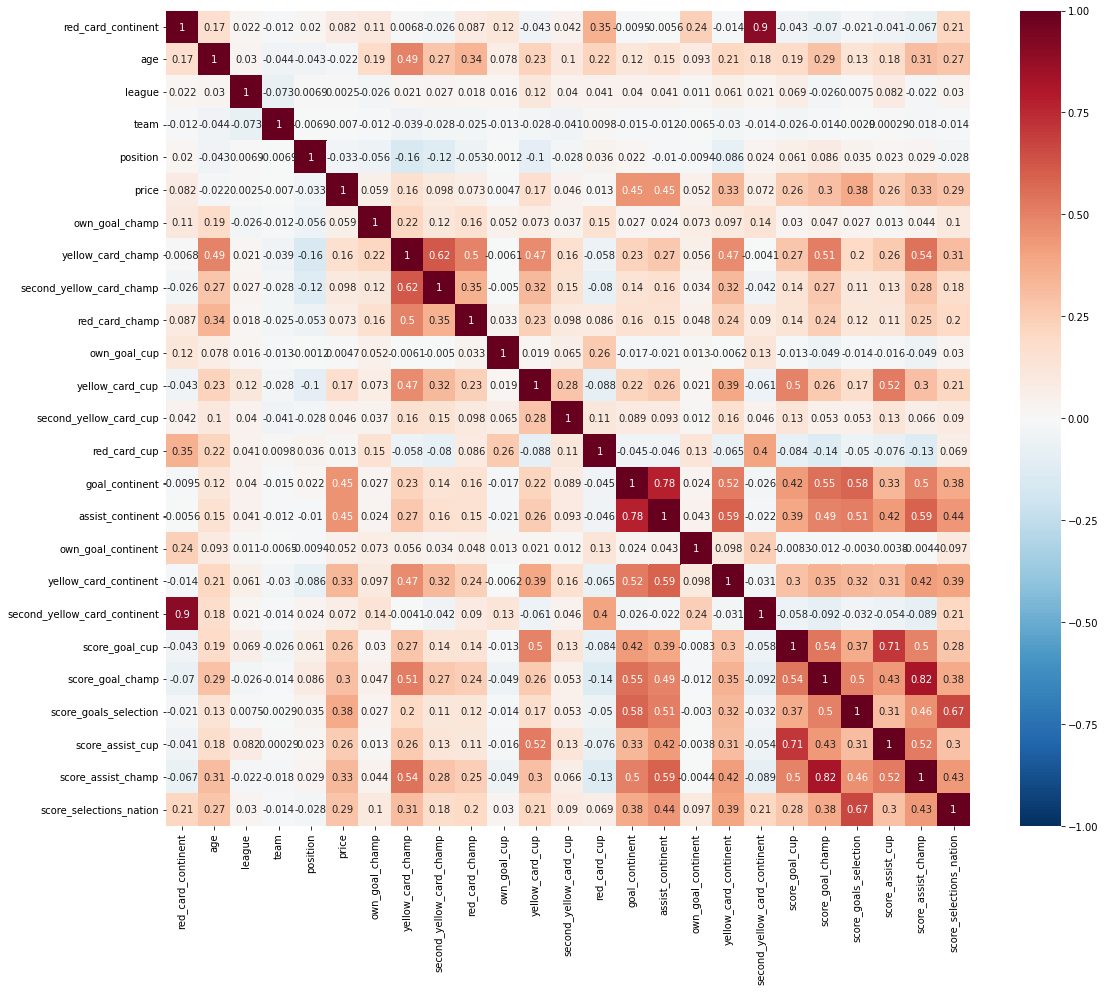

In [87]:
plot_corr(data.df)

## Goalkeeper

/home/goodie/.local/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


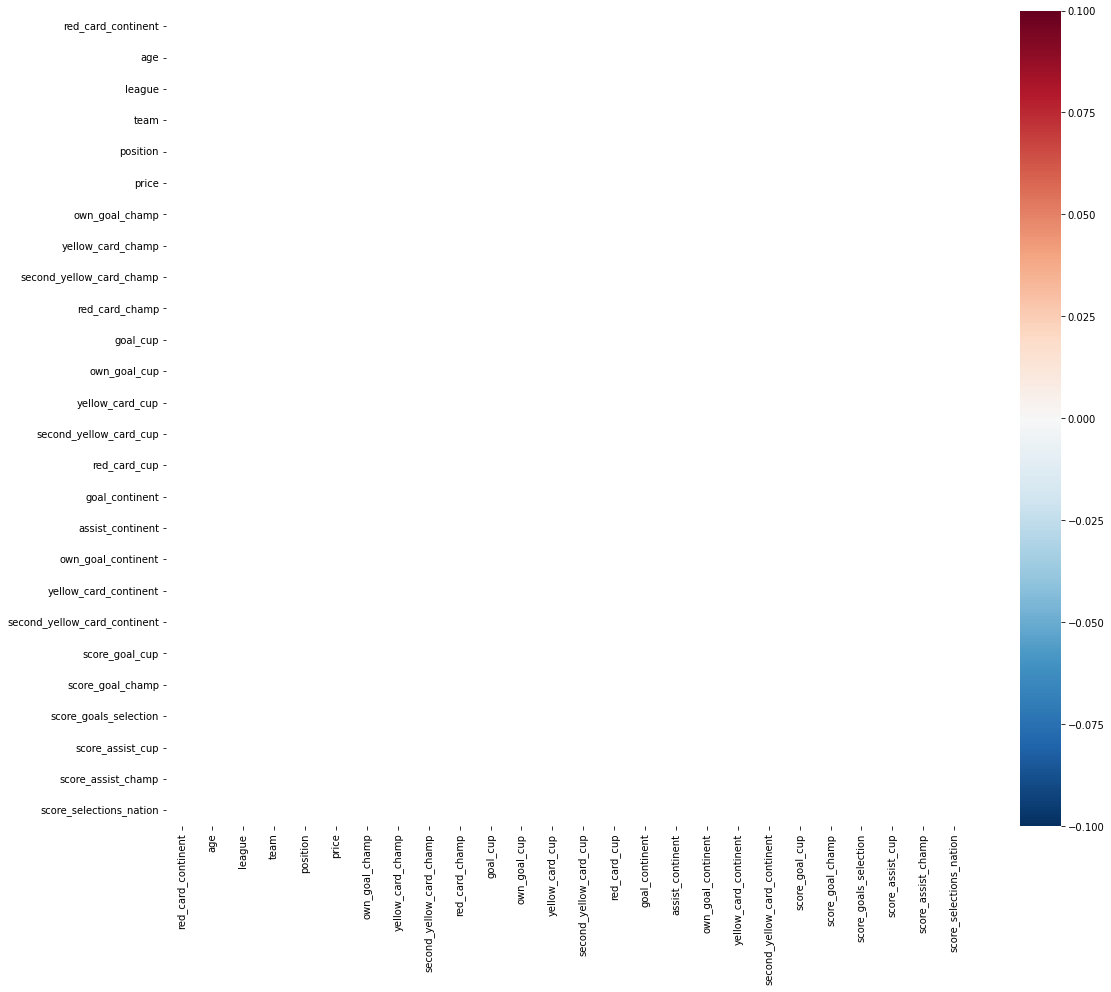

In [56]:
plot_corr(data.filter_by_position(0))

## Defenders

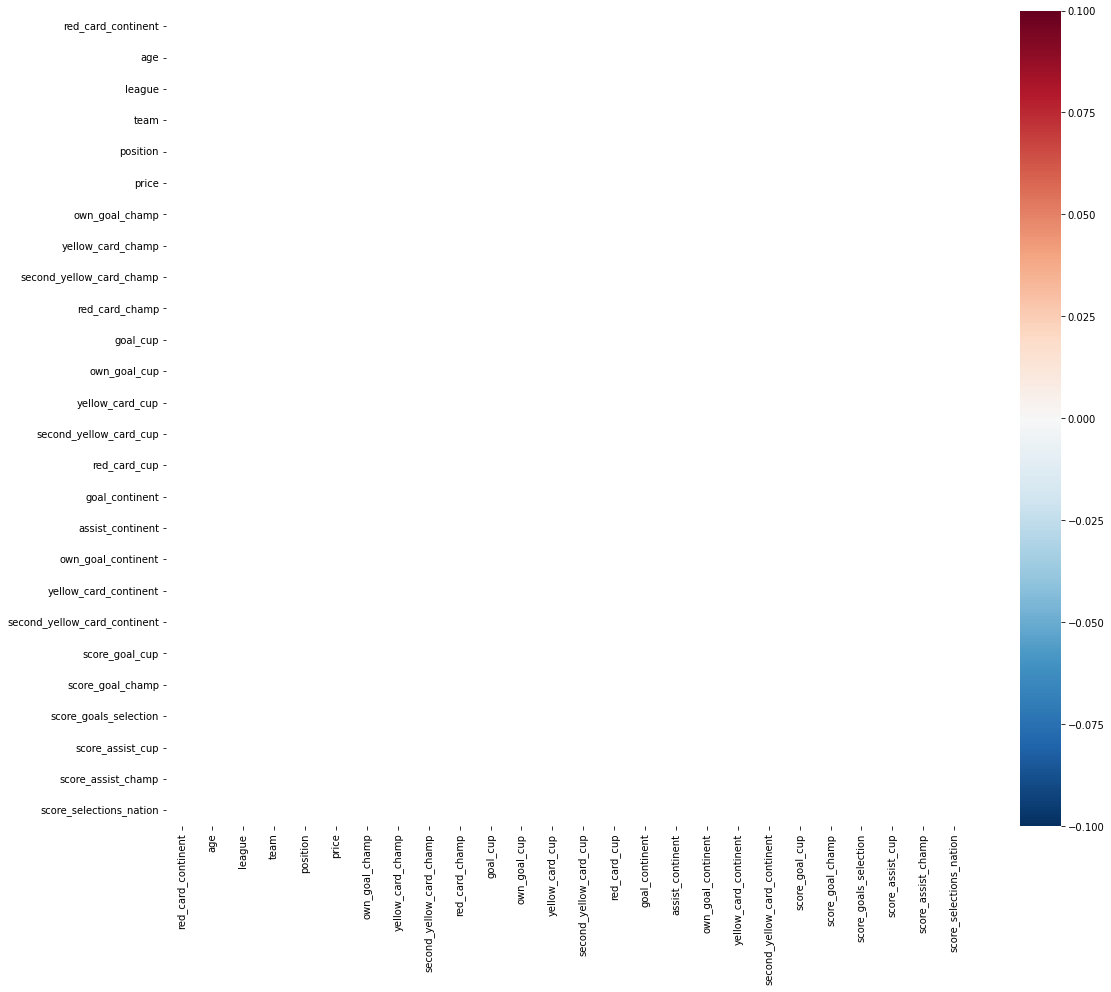

In [57]:
plot_corr(data.filter_by_position(1))

## Midfielders

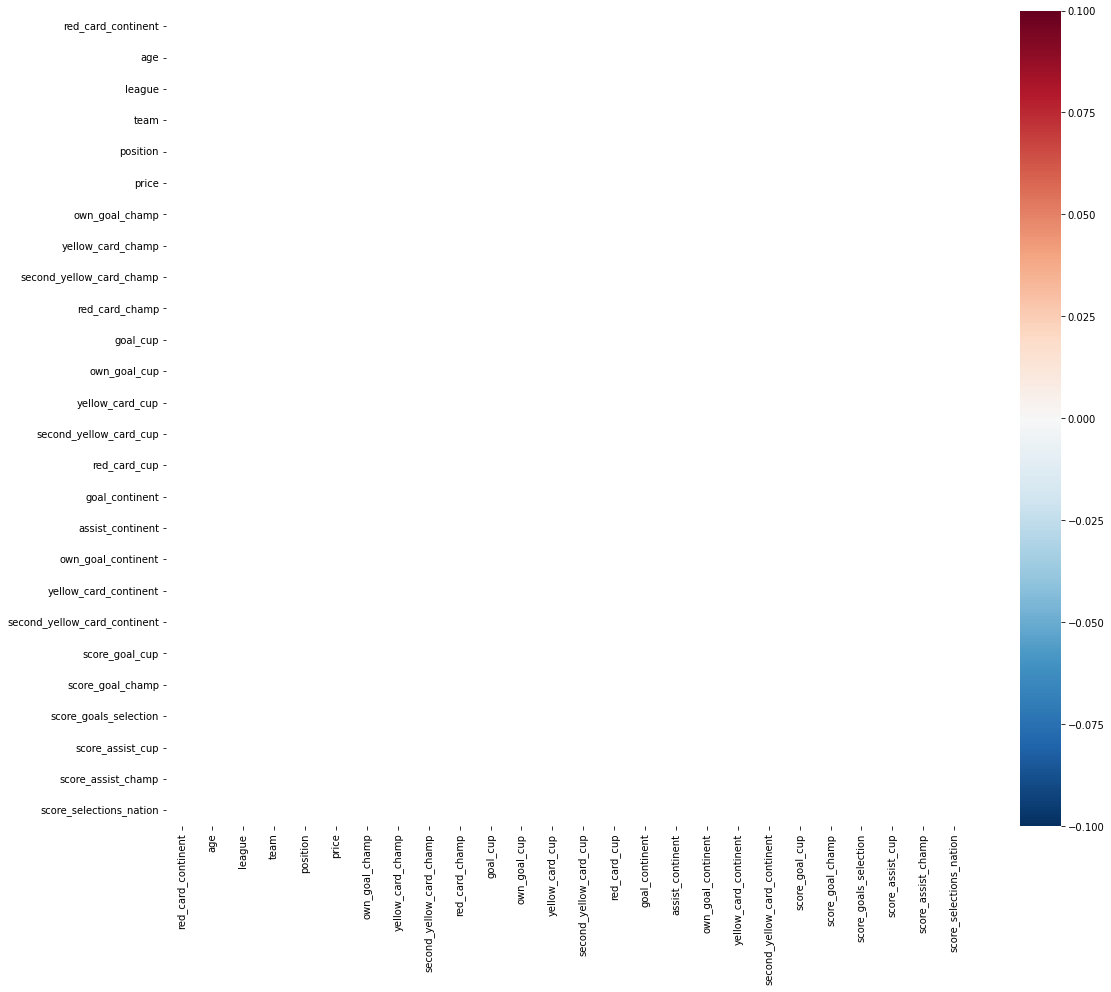

In [58]:
plot_corr(data.filter_by_position(2))

## Forwards

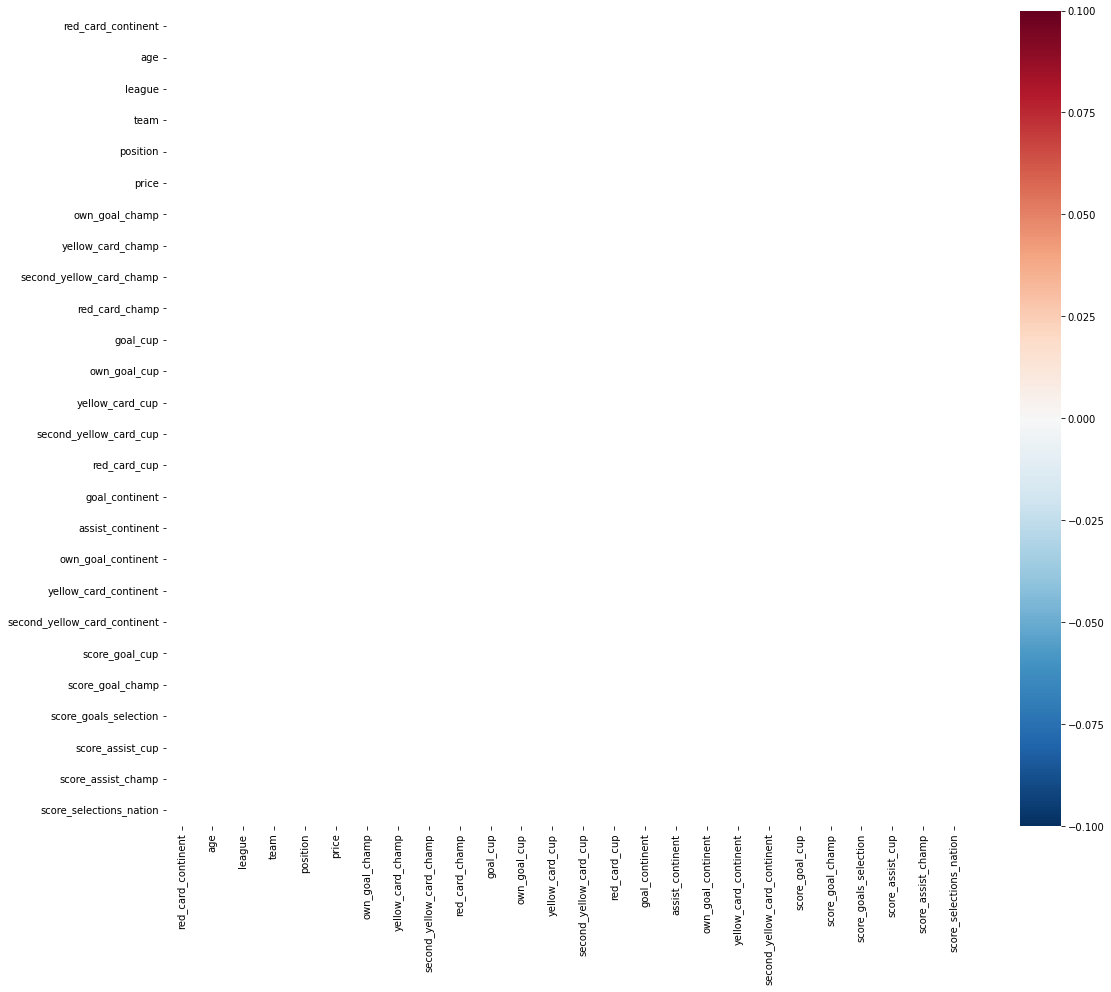

In [59]:
plot_corr(data.filter_by_position(3))

## Forward players in top leagues

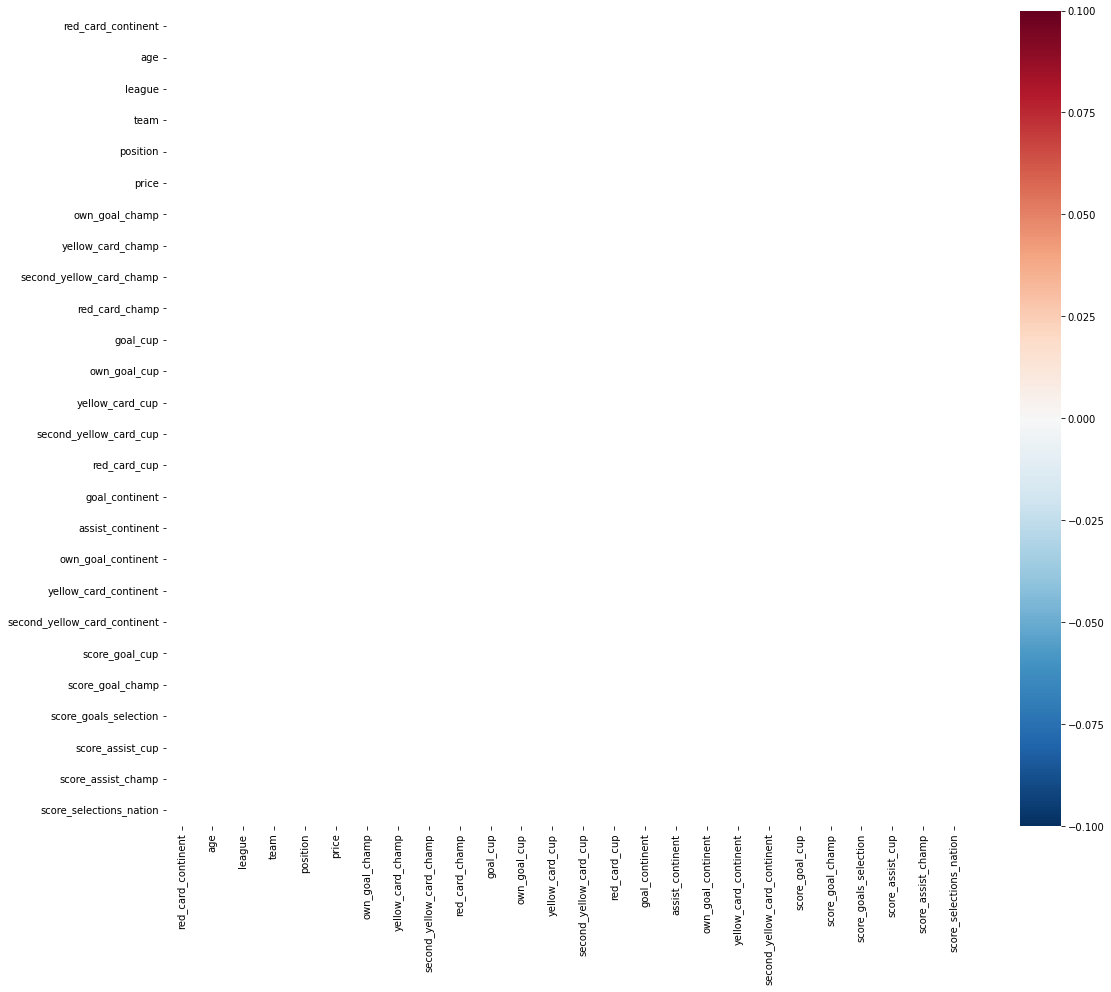

In [60]:
plot_corr(data.filter_top_leagues())

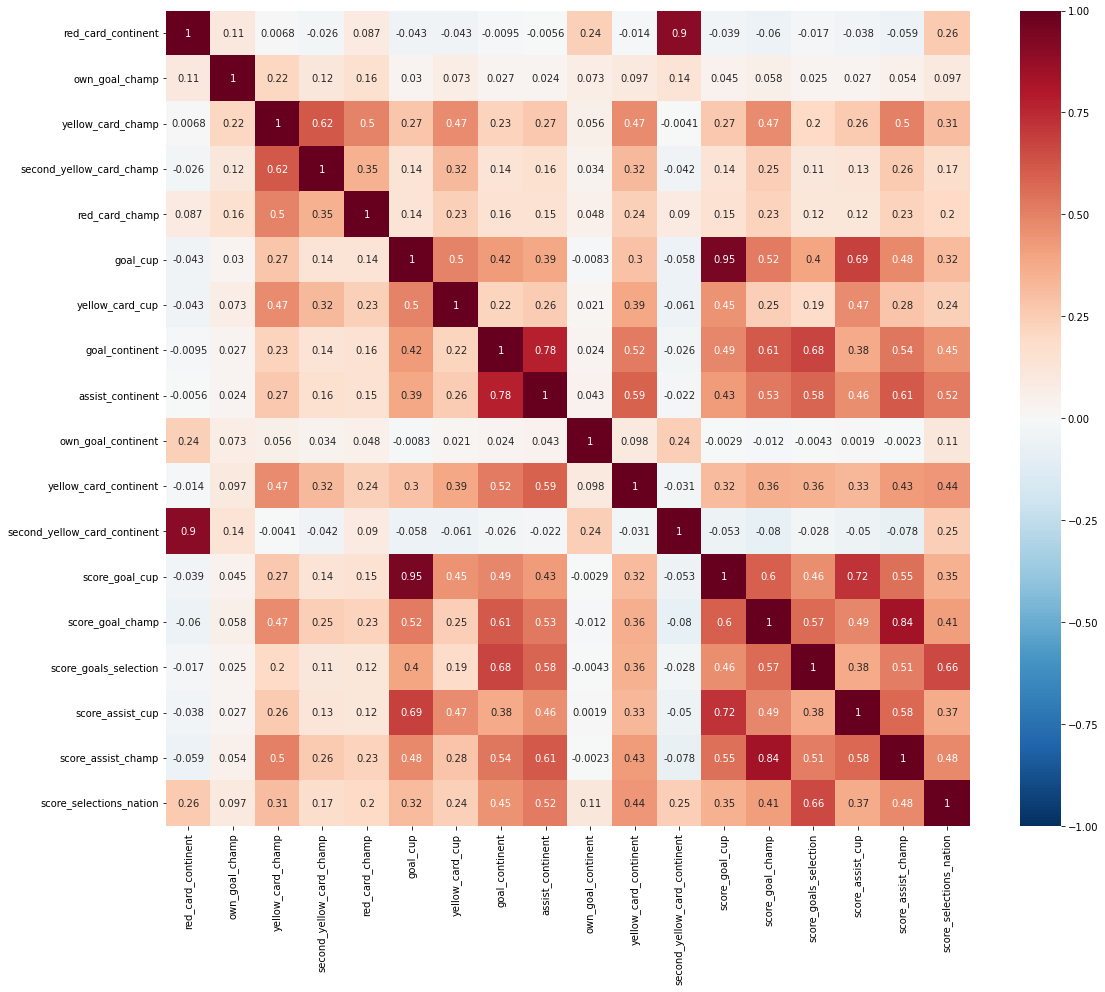

In [61]:
X, y = data.data_correlated()
plot_corr(X)


In [77]:
X.head(2)

,red_card_continent,own_goal_champ,yellow_card_champ,second_yellow_card_champ,red_card_champ,goal_cup,yellow_card_cup,goal_continent,assist_continent,own_goal_continent,yellow_card_continent,second_yellow_card_continent,score_goal_cup,score_goal_champ,score_goals_selection,score_assist_cup,score_assist_champ,score_selections_nation
1019,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1892,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [63]:
X.to_csv("../data/trainX.csv")

In [64]:
y.to_csv("../data/trainY.csv")

### MORE INFO
    * ATTENTION
        - With that data, defenders will be valued poorly. We can't see her performance, because we've got their goals but not how many goals scored the teams against them. Same with Goalkeepers.

    * MISSING INFO
        - Goals /game --> how many minutes to score a goal?
        - Goals in top matches? Finals...
        - Experience in big matches
        - Historical injuries
        - Player mentality
        - Player position during the game
    
    * CURIOUS FACTS TO ADD INFO
        - Goal value increases if the football tendency is to score less goals in a match.
        - Global economy. If more people whats football and moves more money, players value will increase.


    



### LINKS
https://github.com/eddwebster/football_analytics/tree/master/notebooks

https://github.com/JaseZiv/worldfootballR

https://github.com/emordonez/transfermarkt-transfers

https://github.com/sanjitva/Predicting-Football-Player-Transfer-Values